# Example for creating family of Halo via Natural Parameter Continuation

### For halo in Sun-Earth frame

Yuri Shimane

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from tqdm.notebook import tqdm

%matplotlib inline

In [181]:
import sys
sys.path.append('../')   # path to polaris module

import polaris.SolarSystemConstants as sscs
import polaris.Keplerian as kepl
import polaris.Propagator as prop
import polaris.R3BP as r3bp

In [182]:
param_earth_moon = r3bp.get_cr3bp_param('10','399')   # NAIF ID's '399': Earth, '301': Moon
lp = r3bp.lagrangePoints(param_earth_moon.mu)
param_earth_moon.mu

3.003480593992992e-06

In [183]:
# initial guess of halo
haloinit = r3bp.get_halo_approx(mu=param_earth_moon.mu, lp=2, lstar=param_earth_moon.lstar, az_km=120000, family=1, phase=0.0)
haloinit["period_guess"], haloinit["state_guess"]

gammaL: 0.010037119902027047, c2:3.9407609286061818, c3:-2.9799247302579666, c4: 2.9703765384747136
Ax = 214083.55 [km], Ay = 682351.29 [km], Az = 120000.00 [km]
Analytical period = 3.09885969 (non-dim)


(3.098859689307486,
 array([1.00836603e+00, 0.00000000e+00, 7.27930032e-04, 0.00000000e+00,
        9.82119679e-03, 0.00000000e+00]))

### Correct initial guess with single-shooting differential correction

In [184]:
p_conv, state_conv, flag_conv = r3bp.ssdc_periodic_xzplane(param_earth_moon.mu, haloinit["state_guess"], 
                                                           haloinit["period_guess"], fix="z", message=False)
flag_conv

1

### Plot

In [185]:
prop0 = prop.propagate_cr3bp(param_earth_moon.mu, state_conv, p_conv)

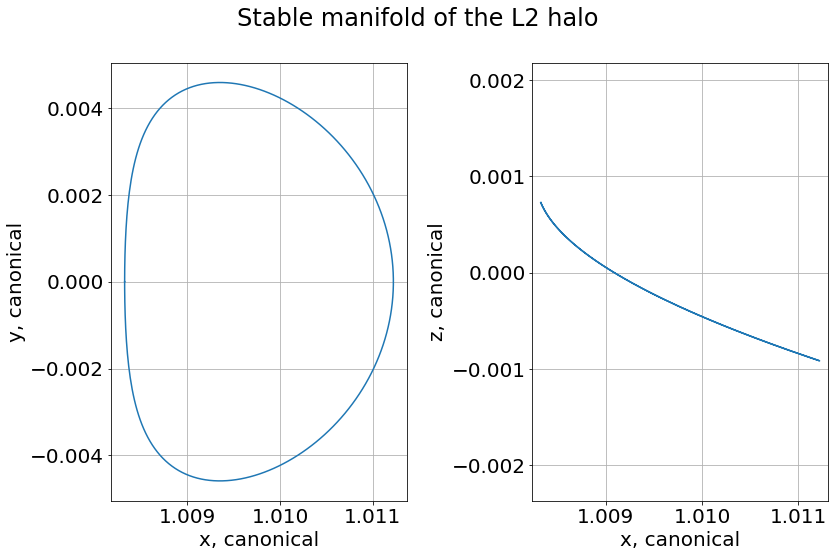

In [186]:
plt.rcParams["font.size"] = 20
fig, axs = plt.subplots(1, 2, figsize=(12,8))
axs[0].plot(prop0["xs"], prop0["ys"])
axs[0].set(xlabel='x, canonical', ylabel='y, canonical')
axs[0].grid(True)

axs[1].plot(prop0["xs"], prop0["zs"])
axs[1].set(xlabel='x, canonical', ylabel='z, canonical')
axs[1].grid(True)

plt.axis("equal")
plt.suptitle('Stable manifold of the L2 halo')
plt.tight_layout(rect=[0, 0.0, 1, 1])
plt.show()

### Create more member

In [187]:
# initial member
# state0  = np.array([1.16935708791412, 0.0, 0.096785570098781, 0.0, -0.19393150190919, 0.0])
# period0 = 3.33357641283143

state0 = state_conv
period0 = p_conv

# initialize list and append initial member
proplst = []
proplst.append( prop.propagate_cr3bp(param_earth_moon.mu, state0, period0) )

# setup array of periods to use
step_period = 0.00001 #-0.0005
stop_period = 4#1.4  #period0 - 1.4
periods = np.arange(period0, stop_period, step_period)

len(periods), stop_period

(89830, 4)

In [188]:
# initialize pandas dataframe
df_keys = ["System", "Family", "mu", "Period", "Jacobi", "Stability", 
           "state_x", "state_y", "state_z", "state_vx", "state_vy", "state_vz",]
famdf = pd.DataFrame( columns=df_keys )
solcount = 0   # number of solutions

# run single shooting
state_iter = state0
p_iter     = period0
for period in tqdm(periods):
    p_iter, state_iter, conv_iter = r3bp.ssdc_periodic_xzplane(param_earth_moon.mu, state_iter, period, 
                                                               fix="period", message=False)
    if conv_iter==1:
        # store propagation output for plotting
        proptmp = prop.propagate_cr3bp(param_earth_moon.mu, state_iter, p_iter, stm_option=True)
        proplst.append( proptmp )
        monodromy = np.reshape( proptmp["stms"][:,-1] , (6,6) )
        # store solution into dataframe
        snew = pd.Series(["Sun_Earth",
                          "l2_halo_southern",
                          param_earth_moon.mu,
                          p_iter,
                          r3bp.jacobiConstant(param_earth_moon.mu, state_iter),
                          r3bp.stabilityIndex(monodromy), 
                          state_iter[0], state_iter[1], state_iter[2], 
                          state_iter[3], state_iter[4], state_iter[5] ], index=df_keys, name=int(solcount))
        famdf = pd.DataFrame.append(famdf, snew)
        solcount += 1
    else:
        print(f'Breaking at {period}!')
        break

Breaking at 3.102516300957134!



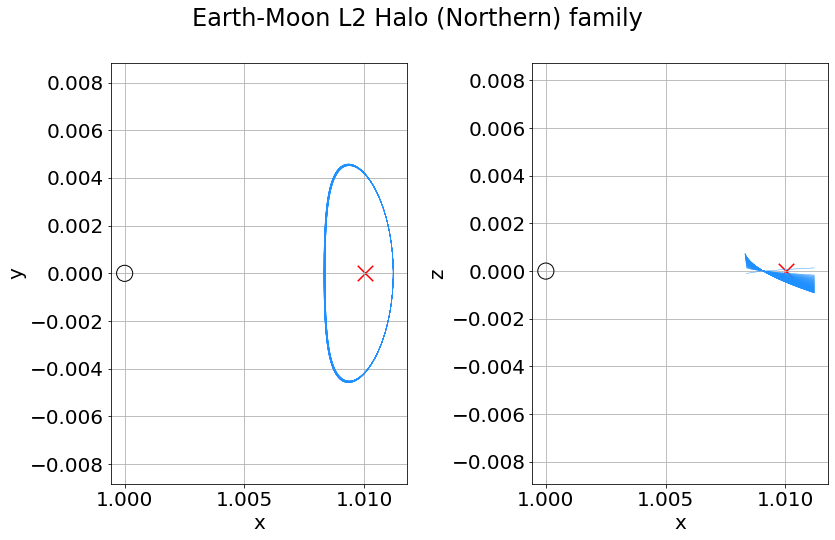

In [190]:
# plot resulting family
plt.rcParams["font.size"] = 20
fig, axs = plt.subplots(1, 2, figsize=(12,8))

for propout in tqdm(proplst):
    axs[0].plot(propout["xs"], propout["ys"], linewidth=0.4, c='dodgerblue', alpha=0.55)
    axs[1].plot(propout["xs"], propout["zs"], linewidth=0.4, c='dodgerblue', alpha=0.55)
    
for idx in range(2):
    axs[idx].grid(True)
    axs[idx].axis("equal")
    axs[idx].scatter(1-param_earth_moon.mu, 0., marker='o', facecolor="none", edgecolor='k', zorder=3, s=260, label='Moon')
    axs[idx].scatter(lp.l2[0], lp.l2[1], marker='x', c='r', s=240)

axs[0].set(xlabel="x", ylabel="y")
axs[1].set(xlabel="x", ylabel="z")

plt.suptitle('Earth-Moon L2 Halo (Northern) family')
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

In [192]:
famdf

,System,Family,mu,Period,Jacobi,Stability,state_x,state_y,state_z,state_vx,state_vy,state_vz
0,Sun_Earth,l2_halo_southern,0.000003,3.101706,3.000814,828.223378,1.008323,0.0,0.000728,0.0,0.009950,0.0
1,Sun_Earth,l2_halo_southern,0.000003,3.101716,3.000814,828.444780,1.008324,0.0,0.000724,0.0,0.009948,0.0
2,Sun_Earth,l2_halo_southern,0.000003,3.101726,3.000814,828.666269,1.008325,0.0,0.000719,0.0,0.009945,0.0
3,Sun_Earth,l2_halo_southern,0.000003,3.101736,3.000814,828.887846,1.008325,0.0,0.000715,0.0,0.009943,0.0
4,Sun_Earth,l2_halo_southern,0.000003,3.101746,3.000814,829.109510,1.008326,0.0,0.000710,0.0,0.009940,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
76,Sun_Earth,l2_halo_southern,0.000003,3.102466,3.000819,845.301306,1.008378,0.0,0.000194,0.0,0.009766,0.0
77,Sun_Earth,l2_halo_southern,0.000003,3.102476,3.000819,845.529456,1.008379,0.0,0.000177,0.0,0.009763,0.0
78,Sun_Earth,l2_halo_southern,0.000003,3.102486,3.000819,845.757696,1.008380,0.0,0.000157,0.0,0.009761,0.0
79,Sun_Earth,l2_halo_southern,0.000003,3.102496,3.000819,845.986027,1.008380,0.0,0.000134,0.0,0.009758,0.0


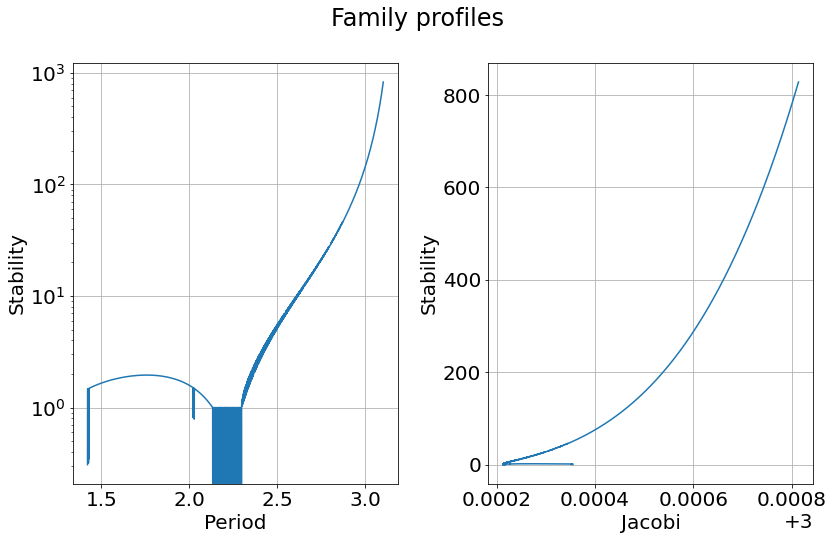

In [169]:
plt.rcParams["font.size"] = 20
fig, axs = plt.subplots(1, 2, figsize=(12,8))
axs[0].semilogy(famdf["Period"], famdf["Stability"])
axs[0].set(xlabel="Period", ylabel="Stability")
axs[0].grid(True)

axs[1].plot(famdf["Jacobi"], famdf["Stability"])
axs[1].set(xlabel="Jacobi", ylabel="Stability")
axs[1].grid(True)

plt.suptitle('Family profiles')
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

### Save resulting family into JSON file

In [ ]:
raise SystemExit("Stop before saving!")

In [194]:
# save output
flename = "l2_halo_southern_test.json"
pathjson = '../data/r3bp/Sun_Earth/' + flename
famdf.to_json(pathjson, orient='index', indent=4, double_precision=15)

print(f'Done! Saved at {pathjson}')

Done! Saved at ../data/r3bp/Sun_Earth/l2_halo_southern_nearPlanar.json
